# Clasificacion de Mensajes de spam y no spam, en el contexto peruano.

## Verificacion de pytorch y GPU

In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("MPS disponible:", torch.backends.mps.is_available())
print("MPS compilado:", torch.backends.mps.is_built())

# Configurar devices
device_cpu = torch.device("cpu")
device_mps = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f"\nDevice CPU: {device_cpu}")
print(f"Device MPS: {device_mps}")

PyTorch version: 2.8.0
MPS disponible: True
MPS compilado: True

Device CPU: cpu
Device MPS: mps


## Librerias a importar

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers
from transformers import (
    RobertaTokenizer, 
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    confusion_matrix
)

/opt/homebrew/Caskroom/miniforge/base/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargar los mensajes - dataset

In [3]:
# Función para cargar los datos
def cargar_datos():
    # Cargar mensajes NO SPAM del dataset_final
    with open('/Users/franspaxi/machine-learning/dataset_final/sms_no_spam_peru.txt', 'r', encoding='utf-8') as f:
        no_spam_lines = f.readlines()
    
    # Cargar mensajes SPAM del dataset_final
    with open('/Users/franspaxi/machine-learning/dataset_final/spam.txt', 'r', encoding='utf-8') as f:
        spam_lines = f.readlines()
    
    no_spam_messages = [line.strip() for line in no_spam_lines if line.strip()]
    spam_messages = [line.strip() for line in spam_lines if line.strip()]
    
    # Crear DataFrame
    data = []
    
    # Agregar mensajes no spam (etiqueta 0)
    for message in no_spam_messages:
        data.append({'text': message, 'label': 0, 'label_name': 'no_spam'})
    
    # Agregar mensajes spam (etiqueta 1)
    for message in spam_messages:
        data.append({'text': message, 'label': 1, 'label_name': 'spam'})
    
    df = pd.DataFrame(data)
    
    print(f"Número total de mensajes: {len(df)}")
    print(f"Número de mensajes no spam: {len(df[df['label'] == 0])}")
    print(f"Número de mensajes spam: {len(df[df['label'] == 1])}")

    return df

# Cargar los datos
df = cargar_datos()

Número total de mensajes: 2000
Número de mensajes no spam: 1000
Número de mensajes spam: 1000


In [4]:
df.head(5)

,text,label,label_name
0,Tu recibo de luz de Electro Puno vence el prox...,0,no_spam
1,¡Atención! El SENAMHI te informa que se prevé ...,0,no_spam
2,Hasta el próximo viernes tienes un descuento d...,0,no_spam
3,Has solicitado un codigo de validación para in...,0,no_spam
4,Te informamos que tu cuenta de agua Sedapal ha...,0,no_spam


In [5]:
df.tail(5)

,text,label,label_name
1995,Caixa bank Lamentamos informarle que su cuenta...,1,spam
1996,BBVA por falta de seguridad web su tarjeta est...,1,spam
1997,Caixa bank XXXXXXX Lamentamos informarle que s...,1,spam
1998,Le informamos que sus tarjetas estan bloqueada...,1,spam
1999,Tu paquete esta guardado en nuestro almacen de...,1,spam


## Preprocesamiento de los datos

Vamos a limpiar los datos reemplazando con etiquetas los números de teléfono, fechas, URLs y otros elementos, para que el modelo generalice mejor.

In [6]:
from transformers import pipeline
import re

# Cargar pipeline de NER con BERT en español
print("🤖 Cargando modelo BERT para NER...")
ner_pipeline = pipeline("ner", 
                        model="mrm8488/bert-spanish-cased-finetuned-ner", 
                        tokenizer="mrm8488/bert-spanish-cased-finetuned-ner", 
                        aggregation_strategy="simple")

def preprocesamiento_data(texto):
    """
    Versión mejorada del preprocesamiento para clasificación de spam
    """
    original = texto
    texto_working = texto.lower()
    
    # 1. NER con BERT PRIMERO (usando texto original para mejor detección)
    if ner_pipeline and len(original) < 400:
        try:
            entities = ner_pipeline(original)
            reemplazos = []
            for entity in entities:
                if entity['entity_group'] == 'PER' and entity['score'] > 0.6:
                    nombre = entity['word'].replace('##', '').strip()
                    if len(nombre) > 2:
                        reemplazos.append((nombre, '[name]'))
                elif entity['entity_group'] == 'ORG' and entity['score'] > 0.6:
                    org = entity['word'].replace('##', '').strip()
                    if len(org) > 2:
                        reemplazos.append((org, '[org]'))
            
            reemplazos.sort(key=lambda x: len(x[0]), reverse=True)
            
            for original_word, token in reemplazos:
                escaped_word = re.escape(original_word)
                pattern = rf'\b{escaped_word}\b'
                texto_working = re.sub(pattern, token, texto_working, flags=re.IGNORECASE)
                
        except Exception as e:
            print(f"Error en NER: {e}")
            pass
    
    # 2. URLs y dominios (MEJORADO - más patrones)
    # URLs completas
    texto_working = re.sub(r'https?://[^\s]+', '[url]', texto_working)
    # URLs sin protocolo
    texto_working = re.sub(r'www\.[^\s]+', '[url]', texto_working)
    # Acortadores de URL
    texto_working = re.sub(r'\b(?:bit\.ly|cutt\.ly|tinyurl\.com|is\.gd|ow\.ly|t\.co|han\.gl|s\.id|rb\.gy)/[^\s]*', '[url]', texto_working)
    # URLs malformadas (como en spam): http // sitio.com
    texto_working = re.sub(r'https?\s*[:/]+\s*[^\s]+', '[url]', texto_working)
    # Dominios sospechosos
    texto_working = re.sub(r'\b\w+\.(com|es|org|net|pe|cl|mx)[^\s]*', '[url]', texto_working)
    
    # 3. Bancos específicos (EXPANDIDO)
    bancos = ['bbva', 'santander', 'bcp', 'interbank', 'scotiabank', 'caixabank', 'bankia', 'ruralvia',
              'bancolombia', 'davivienda', 'banesco', 'falabella', 'ripley', 'caja arequipa', 'caja cusco',
              'banco estado', 'banco chile', 'itau', 'hsbc', 'continental', 'pichincha', 'banco peru',
              'colpatria', 'avvillas', 'sabadell', 'kutxabank', 'bankinter', 'ibercaja', 'unicaja',
              'openbank', 'ing', 'liberbank', 'abanca', 'cajamar']
    
    for banco in bancos:
        if banco:
            # Escapar espacios en nombres de bancos
            banco_escaped = banco.replace(' ', r'\s+')
            texto_working = re.sub(rf'\b{banco_escaped}\b', '[bank]', texto_working, flags=re.IGNORECASE)

    # 4. Servicios comunes (EXPANDIDO)
    servicios = ['correos', 'movistar', 'yape', 'rappi', 'uber', 'netflix', 'dhl', 'amazon', 'serpost',
                 'claro', 'entel', 'wom', 'sedapal', 'electro puno', 'electro arequipa', 'luz del sur',
                 'essalud', 'minsa', 'senamhi', 'sunat', 'mercado libre', 'spotify', 'whatsapp',
                 'telegram', 'facebook', 'google', 'apple', 'microsoft', 'paypal', 'western union',
                 'moneygram', 'plin', 'tunki', 'lukita', 'izi pay', 'cabify', 'beat', 'glovo',
                 'pedidos ya', 'ifood', 'plaza vea', 'tottus', 'metro', 'wong', 'vivanda']
    
    for servicio in servicios:
        if servicio:
            servicio_escaped = servicio.replace(' ', r'\s+')
            texto_working = re.sub(rf'\b{servicio_escaped}\b', '[service]', texto_working, flags=re.IGNORECASE)
    
    # 5. Teléfonos (MEJORADO) - ANTES QUE NÚMEROS GENÉRICOS
    # Teléfonos peruanos
    texto_working = re.sub(r'\+?51[-\s]*[9]\d{8}|\b[9]\d{8}\b', '[phone]', texto_working)
    # Otros formatos de teléfonos internacionales
    texto_working = re.sub(r'\+?\d{1,3}[-\s]*\d{6,10}', '[phone]', texto_working)
    # Teléfonos con formato (xxx) xxx-xxxx
    texto_working = re.sub(r'\(\d{3}\)\s*\d{3}[-\s]*\d{4}', '[phone]', texto_working)
    
    # 6. Fechas y horas (ANTES QUE MONTOS) - CORREGIDO
    # Fechas completas dd/mm/yyyy, dd-mm-yyyy, dd.mm.yyyy
    texto_working = re.sub(r'\b\d{1,2}[/\-\.]\d{1,2}[/\-\.]\d{2,4}\b', '[date]', texto_working)
    # Fechas yyyy-mm-dd
    texto_working = re.sub(r'\b\d{4}[\-/]\d{1,2}[\-/]\d{1,2}\b', '[date]', texto_working)
    # Horas hh:mm AM/PM - ANTES QUE NÚMEROS
    texto_working = re.sub(r'\b\d{1,2}:\d{2}(?:\s*[ap]m)?\b', '[time]', texto_working)
    # Horas con segundos
    texto_working = re.sub(r'\b\d{1,2}:\d{2}:\d{2}\b', '[time]', texto_working)
    
    # 7. Tarjetas de crédito - ANTES QUE NÚMEROS GENÉRICOS
    # Números de tarjeta completos (parciales por seguridad en spam)
    texto_working = re.sub(r'\b\d{4}[-\s]*\*+[-\s]*\*+[-\s]*\d{4}\b', '[card]', texto_working)
    texto_working = re.sub(r'terminada?\s+en\s+\d{4}', 'terminada en [card]', texto_working)
    
    # 8. IPs - ANTES QUE NÚMEROS GENÉRICOS
    texto_working = re.sub(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', '[ip]', texto_working)
    
    # 9. Montos de dinero (MEJORADO Y REORDENADO)
    # Soles peruanos con formato específico
    texto_working = re.sub(r's/\.?\s*\d+(?:[.,]\d+)?', '[amount]', texto_working)
    texto_working = re.sub(r'\d+(?:[.,]\d+)?\s*(?:soles?|nuevos?\s*soles?)', '[amount]', texto_working)
    # Dólares con símbolos
    texto_working = re.sub(r'\$\s*\d+(?:[.,]\d+)?', '[amount]', texto_working)
    texto_working = re.sub(r'usd?\s*\d+(?:[.,]\d+)?', '[amount]', texto_working)
    texto_working = re.sub(r'\d+(?:[.,]\d+)?\s*(?:dólares?|dolares?|usd?)', '[amount]', texto_working)
    # Euros con símbolos
    texto_working = re.sub(r'€\s*\d+(?:[.,]\d+)?', '[amount]', texto_working)
    texto_working = re.sub(r'eur\s*\d+(?:[.,]\d+)?', '[amount]', texto_working)
    texto_working = re.sub(r'\d+(?:[.,]\d+)?\s*(?:euros?|eur)', '[amount]', texto_working)
    # Pesos (Chile, Colombia, México)
    texto_working = re.sub(r'\d+(?:[.,]\d+)?\s*(?:pesos?|cop|clp|mxn)', '[amount]', texto_working)
    # Bolivares
    texto_working = re.sub(r'\d+(?:[.,]\d+)?\s*(?:bolívares?|bolivares?|bs\.?)', '[amount]', texto_working)
    # Formato genérico de moneda con puntos de miles - MÁS ESPECÍFICO
    texto_working = re.sub(r'\b\d{1,3}(?:[.,]\d{3}){2,}(?:[.,]\d{2})?\b', '[amount]', texto_working)
    
    # 10. Códigos específicos (ANTES QUE NÚMEROS GENÉRICOS)
    # Códigos de verificación
    texto_working = re.sub(r'código[:\s]+[a-zA-Z0-9]+', 'código [code]', texto_working)
    texto_working = re.sub(r'ref[:\s]+[a-zA-Z0-9]+', 'ref [code]', texto_working)
    texto_working = re.sub(r'token[:\s]+[a-zA-Z0-9]+', 'token [code]', texto_working)
    # Códigos alfanuméricos largos
    texto_working = re.sub(r'\b[A-Z]{2,}\d+[A-Z]*\b', '[code]', texto_working)
    # Códigos de seguimiento
    texto_working = re.sub(r'seguimiento[:\s]+[a-zA-Z0-9]+', 'seguimiento [code]', texto_working)
    # Números de transacción
    texto_working = re.sub(r'transacci[oó]n[:\s#]*[a-zA-Z0-9]+', 'transacción [code]', texto_working)
    
    # 11. Direcciones de email
    texto_working = re.sub(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b', '[email]', texto_working)
    
    # 12. Direcciones físicas
    # Avenidas, calles, etc.
    texto_working = re.sub(r'\b(?:av|avenida|calle|jr|jirón|psje|pasaje)\.?\s+[a-zA-Z0-9\s]+\d+', '[address]', texto_working)
    
    # 13. Números largos (4 o más dígitos) - AL FINAL Y MÁS ESPECÍFICO
    # Solo números de 6+ dígitos que no sean años, fechas, horas, etc.
    texto_working = re.sub(r'\b(?!(?:19|20)\d{2}\b)(?!\d{1,2}[:/\-\.]\d)(?!\d{1,2}:\d{2})\d{6,}\b', '[number]', texto_working)
    
    # 14. Limpiar espacios múltiples
    return re.sub(r'\s+', ' ', texto_working).strip()

🤖 Cargando modelo BERT para NER...


Some weights of the model checkpoint at mrm8488/bert-spanish-cased-finetuned-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [7]:
# 🧹 Aplicar preprocesamiento y crear tabla comparativa
print("🧹 Aplicando preprocesamiento a los mensajes...")

# Aplicar la función de preprocesamiento
df['text_clean'] = df['text'].apply(preprocesamiento_data)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🧹 Aplicando preprocesamiento a los mensajes...


In [8]:
df.head(10)

,text,label,label_name,text_clean
0,Tu recibo de luz de Electro Puno vence el prox...,0,no_spam,tu recibo de luz de [service] vence el proximo...
1,¡Atención! El SENAMHI te informa que se prevé ...,0,no_spam,¡atención! el [org] te informa que se prevé un...
2,Hasta el próximo viernes tienes un descuento d...,0,no_spam,hasta el próximo viernes tienes un descuento d...
3,Has solicitado un codigo de validación para in...,0,no_spam,has solicitado un codigo de validación para in...
4,Te informamos que tu cuenta de agua Sedapal ha...,0,no_spam,te informamos que tu cuenta de agua [service] ...
5,Recuerda pagar tu recibo Movil de 50 soles que...,0,no_spam,recuerda pagar tu recibo movil de [amount] que...
6,Felicidades! Activaste tu paquete de 100MB x 1...,0,no_spam,felicidades! activaste tu paquete de 100mb x 1...
7,"¡Felicidades! Has aprobado el préstamo de $10,...",0,no_spam,¡felicidades! has aprobado el préstamo de [amo...
8,Ha sido asignado a reparto tu paquete de 100MB...,0,no_spam,ha sido asignado a reparto tu paquete de 100mb...
9,"Hola, te informamos que tu cuenta de luz con E...",0,no_spam,"hola, te informamos que tu cuenta de luz con [..."


In [9]:
df.tail(10)

,text,label,label_name,text_clean
1990,Bankia Estimado cliente a partir del 04/06/202...,1,spam,[bank] estimado cliente a partir del [date] su...
1991,CaixaBank Lamentamos informarle que su cuenta ...,1,spam,[bank] lamentamos informarle que su cuenta ha ...
1992,Tu paquete esta guardado en nuestro almacen de...,1,spam,tu paquete esta guardado en nuestro almacen de...
1993,Bankia CaixaBank apartir del 25/06/2021 no pod...,1,spam,[name] [bank] apartir del [date] no podra util...
1994,CaixaBank Lamentamos informarle que su cuenta ...,1,spam,[bank] lamentamos informarle que su cuenta ha ...
1995,Caixa bank Lamentamos informarle que su cuenta...,1,spam,[org] lamentamos informarle que su cuenta ha s...
1996,BBVA por falta de seguridad web su tarjeta est...,1,spam,[bank] por falta de seguridad web su tarjeta e...
1997,Caixa bank XXXXXXX Lamentamos informarle que s...,1,spam,[org] lamentamos informarle que su cuenta ha s...
1998,Le informamos que sus tarjetas estan bloqueada...,1,spam,le informamos que sus tarjetas estan bloqueada...
1999,Tu paquete esta guardado en nuestro almacen de...,1,spam,tu paquete esta guardado en nuestro almacen de...


In [10]:
# 📋 Tabla más detallada con ejemplos específicos
print("\n=== EJEMPLOS DETALLADOS DE TRANSFORMACIONES ===")

# Ejemplos específicos que muestran diferentes tipos de transformaciones
ejemplos_detallados = [
    "BBVA Estimado Juan, su cuenta tiene S/150.50 pendientes. Llame al +51 987654321",
    "Hola Jose, visita www.banco-falso.com para validar código: ABC123",
    "SANTANDER: Su tarjeta termina en 1234 vence el 15/12/2024 a las 3:30 PM",
    "Rappi te envía un código de verificación: 789456. No lo compartas.",
    "Netflix ha suspendido su cuenta. Pague €12.99 en http://fake-netflix.com",
    "Movistar informa: Su factura de S/.89.90 vence mañana 25/11/2023"
]

print("\n📝 Transformaciones paso a paso:")
for i, ejemplo in enumerate(ejemplos_detallados, 1):
    procesado = preprocesamiento_data(ejemplo)
    print(f"\n{i}. Original:")
    print(f"   {ejemplo}")
    print(f"   Procesado:")
    print(f"   {procesado}")
    print("-" * 80)

# 📈 Estadísticas del preprocesamiento
print("\n=== ESTADÍSTICAS DEL PREPROCESAMIENTO ===")
print(f"Total de mensajes procesados: {len(df)}")
print(f"Mensajes SPAM: {len(df[df['label'] == 1])}")
print(f"Mensajes NO SPAM: {len(df[df['label'] == 0])}")

# Calcular reducción promedio de longitud
longitud_original = df['text'].str.len().mean()
longitud_procesada = df['text_clean'].str.len().mean()
reduccion_porcentaje = ((longitud_original - longitud_procesada) / longitud_original) * 100

print(f"\nLongitud promedio original: {longitud_original:.1f} caracteres")
print(f"Longitud promedio procesada: {longitud_procesada:.1f} caracteres")
print(f"Reducción promedio: {reduccion_porcentaje:.1f}%")

# 🔍 Conteo de tokens especiales encontrados
tokens_especiales = ['[bank]', '[service]', '[phone]', '[amount]', '[url]', '[date]', '[time]', '[code]', '[number]', '[name]', '[org]']
print(f"\n=== CONTEO DE TOKENS ESPECIALES DETECTADOS ===")

for token in tokens_especiales:
    count = df['text_clean'].str.contains(token, regex=False).sum()
    if count > 0:
        print(f"{token}: {count} mensajes")

print("\n✅ Preprocesamiento completado")


=== EJEMPLOS DETALLADOS DE TRANSFORMACIONES ===

📝 Transformaciones paso a paso:

1. Original:
   BBVA Estimado Juan, su cuenta tiene S/150.50 pendientes. Llame al +51 987654321
   Procesado:
   [org] estimado [name], su cuenta tiene [amount] pendientes. llame al [phone]
--------------------------------------------------------------------------------

2. Original:
   Hola Jose, visita www.banco-falso.com para validar código: ABC123
   Procesado:
   hola [name], visita [url] para validar código [code]
--------------------------------------------------------------------------------

3. Original:
   SANTANDER: Su tarjeta termina en 1234 vence el 15/12/2024 a las 3:30 PM
   Procesado:
   [bank]: su tarjeta termina en 1234 vence el [date] a las [time]
--------------------------------------------------------------------------------

4. Original:
   Rappi te envía un código de verificación: 789456. No lo compartas.
   Procesado:
   [service] te envía un código [code] verificación: [number]. 

## Análisis de palabras más frecuentes

Vamos a analizar qué palabras son más comunes en los mensajes de spam vs no spam.

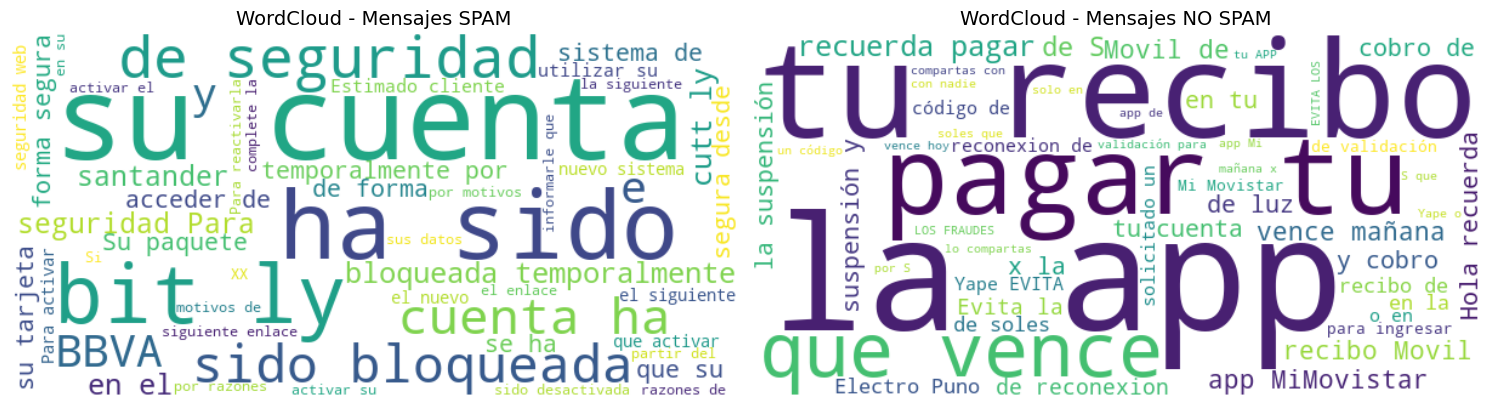

In [11]:
from collections import Counter

# Separar mensajes por categoría y crear texto combinado
spam_text = df[df['label'] == 1]['text'].str.cat(sep=' ')
no_spam_text = df[df['label'] == 0]['text'].str.cat(sep=' ')

# Contar palabras más frecuentes
spam_counter = Counter(spam_text.split()).most_common(10)
no_spam_counter = Counter(no_spam_text.split()).most_common(10)

# Crear y mostrar WordClouds
spam_wordcloud = WordCloud(width=600, height=300, background_color='white', max_words=50, random_state=42).generate(spam_text)
no_spam_wordcloud = WordCloud(width=600, height=300, background_color='white', max_words=50, random_state=42).generate(no_spam_text)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('WordCloud - Mensajes SPAM', fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(no_spam_wordcloud, interpolation='bilinear')
plt.title('WordCloud - Mensajes NO SPAM', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

## División de datos

Vamos a dividir los datos en 80% entrenamiento, 10% validación y 10% test.

In [12]:
# Crear índices para dividir manteniendo correspondencia
indices = np.arange(len(df))

# División usando índices
train_idx, remaining_idx, y_train, y_remaining = train_test_split(
    indices,                    # ← Lo que se divide (índices 0,1,2,3...)
    df['label'].values,         # ← Las etiquetas correspondientes [0,1,0,1...]
    test_size=0.2,             # ← 20% para remaining
    random_state=42,           # ← Semilla para reproducibilidad
    stratify=df['label'].values # ← Mantener proporción de spam/no-spam
)

val_idx, test_idx, y_val, y_test = train_test_split(
    remaining_idx, y_remaining, test_size=0.5, random_state=42, stratify=y_remaining
)

# Asignar datos usando los índices
x_train = df.iloc[train_idx]['text_clean'].values
x_val = df.iloc[val_idx]['text'].values         
x_test = df.iloc[test_idx]['text'].values         

# Mostrar resultados
print(f"\nDivisión final:")
print(f"Entrenamiento: {len(x_train)} ejemplos ({len(x_train)/len(df)*100:.0f}%)")
print(f"Validación: {len(x_val)} ejemplos ({len(x_val)/len(df)*100:.0f}%)")
print(f"Test: {len(x_test)} ejemplos ({len(x_test)/len(df)*100:.0f}%)")

print(f"\nDistribución de clases:")
print(f"Train - Spam: {sum(y_train)}, No Spam: {len(y_train) - sum(y_train)}")
print(f"Val   - Spam: {sum(y_val)}, No Spam: {len(y_val) - sum(y_val)}")
print(f"Test  - Spam: {sum(y_test)}, No Spam: {len(y_test) - sum(y_test)}")

# 🔍 Verificar tipos de datos
print(f"\n🔍 Verificación:")
print(f"Train (procesado): {x_train[0]}")
print(f"Validación (original): {x_val[0]}")
print(f"Test (original): {x_test[0]}")


División final:
Entrenamiento: 1600 ejemplos (80%)
Validación: 200 ejemplos (10%)
Test: 200 ejemplos (10%)

Distribución de clases:
Train - Spam: 800, No Spam: 800
Val   - Spam: 100, No Spam: 100
Test  - Spam: 100, No Spam: 100

🔍 Verificación:
Train (procesado): [org] informa verifi que sus datos ante de xx horas para evitar el bloqueo de su cuenta haciendo clic en [url]
Validación (original): Obten 30% de dscto en tu plan por 1 mes desde la web aqui https://www.entel.pe/sxg.
Test (original): BBVA Su cuenta ha sido suspendida temporalmente por seguridad para desbloquearla confirme sus datos biométricos en el siguiente link cutt.ly/ QTxxtRc


## Funcion para convertir texto a token

Convierte texto legible por humanos a tokens que RoBERTa puede procesar. 

Ejemplo: Texto sin procesar como "Hola, ¿cómo estás?"
Convierte a tokens: [0, 31414, 6, 16466, 32, 11842, 116, 2] (números que RoBERTa entiende)

In [13]:
class TextClassificationDataset(Dataset):
    def __init__(self, message_texts, spam_labels, text_tokenizer, max_token_length=512):
        self.message_texts = message_texts
        self.spam_labels = spam_labels
        self.text_tokenizer = text_tokenizer
        self.max_token_length = max_token_length
    
    def __len__(self):
        return len(self.message_texts)
    
    def __getitem__(self, message_index):
        current_message = str(self.message_texts[message_index])
        current_label = self.spam_labels[message_index]
        
        # Convertir texto a tokens para RoBERTa
        tokenized_message = self.text_tokenizer(
            current_message,
            truncation=True,
            padding='max_length',
            max_length=self.max_token_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': tokenized_message['input_ids'].flatten(),
            'attention_mask': tokenized_message['attention_mask'].flatten(),
            'labels': torch.tensor(current_label, dtype=torch.long)
        }

print("✅ Clase SpamDataset definida correctamente")

✅ Clase SpamDataset definida correctamente


## Configuracion de la Arquitectura BETO

Porque BETO? 

- Especializado en español: Mejor comprensión del contexto peruano
- Tamaño adecuado: ~110M parámetros, más apropiado para tu dataset
- Mejor rendimiento esperado: Para spam en español
- Comunidad activa: Ampliamente usado en NLP en español

In [14]:
# Configuración del modelo RoBERTa para clasificación de spam
from transformers import BertForSequenceClassification, BertTokenizer

model_name = 'dccuchile/bert-base-spanish-wwm-uncased'
spam_tokenizer = BertTokenizer.from_pretrained(model_name)
spam_classifier_model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

print(spam_classifier_model)

# Información del modelo cargado
total_trainable_params = sum(p.numel() for p in spam_classifier_model.parameters() if p.requires_grad)
print(f"✅ Modelo cargado: {model_name}")
print(f"📊 Parámetros entrenables: {total_trainable_params:,}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Transferimos el modelo BETO al GPU/MPS.

In [15]:
# Definir el dispositivo a usar
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Transferir modelo a GPU/MPS si está disponible
spam_classifier_model.to(device)

print(f"🔧 Dispositivo: {device}")

🔧 Dispositivo: mps


## Crear datasets y dataloaders

In [16]:
max_length = 128
batch_size = 8

# Crear datasets: train y val usan datos procesados, test también usa procesados para el modelo
train_dataset = TextClassificationDataset(x_train, y_train, spam_tokenizer, max_length)
val_dataset = TextClassificationDataset(x_val, y_val, spam_tokenizer, max_length)
test_dataset = TextClassificationDataset(x_test, y_test, spam_tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders creados:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

DataLoaders creados:
Train batches: 200
Val batches: 25
Test batches: 25


## Funcion para entrenar y evaluar el modelo

In [17]:
import time
import copy

train_losses = []
train_acc = []
val_losses = []
val_acc = []

def train_model(model, criterion, optimizer, scheduler, num_epochs):  
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_train = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 25)
    
        if scheduler is not None:
            scheduler.step()
        model.train()
    
        running_loss = 0.0
        running_corrects = 0.0
    
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
        
            optimizer.zero_grad()
        
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
        
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, 1)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()  # PRIMERO optimizer
            if scheduler is not None:
                scheduler.step()  # DESPUÉS scheduler
        
            running_loss += loss.item() * input_ids.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss_train = running_loss / len(train_dataset)
        epoch_acc_train = running_corrects.float() / len(train_dataset)  # Cambiado: .double() → .float()
    
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))
        
        train_losses.append(epoch_loss_train)
        train_acc.append(epoch_acc_train.item())  # Agregar .item() para convertir a Python float
        
        if epoch_acc_train > best_acc_train:
              best_acc_train = epoch_acc_train
        
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
    
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
        
            with torch.set_grad_enabled(False):
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                logits = outputs.logits
                _, preds = torch.max(logits, 1)
            
                running_loss += loss.item() * input_ids.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss_val = running_loss / len(val_dataset)
        epoch_acc_val = running_corrects.float() / len(val_dataset)  # Cambiado: .double() → .float()
                   
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
                      
        val_losses.append(epoch_loss_val)
        val_acc.append(epoch_acc_val.item())  # Agregar .item() para convertir a Python float

        with open('clasificacion_spam_log.txt', 'a') as file:
            file.write(f'Epoch {epoch}/{num_epochs-1}\n')
            file.write(f'Train Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f}\n')
            file.write(f'Val Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}\n')
            file.write('-' * 50 + '\n')
        
        # Guardar el mejor modelo basado en la precisión de validación (Early Stopping)
        if epoch_acc_val > best_acc:
              best_acc = epoch_acc_val
              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(best_model_wts, 'clasificacion_spam_model.pth')
              
    time_elapsed = time.time() - since
    print("####################################################")
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best train accuracy: {:.4f}'.format(best_acc_train))
    print('Best val accuracy: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

## Funcion para realizar el test del Modelo Entrenado

In [18]:
def test_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, 1)

            running_loss += loss.item() * input_ids.size(0)
            running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.float() / len(test_dataset)  # Cambiado: .double() → .float()

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))
    return test_model

## Hiperparametros y Ejecucion del Entrenamiento del modelo

In [19]:
# Hiperparámetros
epochs = 15
learning_rate = 2e-5

optimizer = AdamW(spam_classifier_model.parameters(), lr=learning_rate, eps=1e-8)

criterion = nn.CrossEntropyLoss()

# Scheduler 
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(train_loader),  # Warmup steps
    num_training_steps=len(train_loader) * epochs
)

# Ejecutar entrenamiento
spam_classifier_model_trained = train_model(
    spam_classifier_model, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=epochs
)

/opt/homebrew/Caskroom/miniforge/base/envs/torch2/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0/14
-------------------------
Train Loss: 0.1879 Acc: 0.9325
Val Loss: 0.0332 Acc: 0.9950
Epoch 1/14
-------------------------
Train Loss: 0.0176 Acc: 0.9950
Val Loss: 0.0389 Acc: 0.9950
Epoch 2/14
-------------------------
Train Loss: 0.0066 Acc: 0.9981
Val Loss: 0.0063 Acc: 0.9950
Epoch 3/14
-------------------------
Train Loss: 0.0002 Acc: 1.0000
Val Loss: 0.0078 Acc: 0.9950
Epoch 4/14
-------------------------
Train Loss: 0.0000 Acc: 1.0000
Val Loss: 0.0030 Acc: 1.0000
Epoch 5/14
-------------------------
Train Loss: 0.0000 Acc: 1.0000
Val Loss: 0.0013 Acc: 1.0000
Epoch 6/14
-------------------------
Train Loss: 0.0000 Acc: 1.0000
Val Loss: 0.0005 Acc: 1.0000
Epoch 7/14
-------------------------
Train Loss: 0.0000 Acc: 1.0000
Val Loss: 0.0003 Acc: 1.0000
Epoch 8/14
-------------------------
Train Loss: 0.0000 Acc: 1.0000
Val Loss: 0.0002 Acc: 1.0000
Epoch 9/14
-------------------------
Train Loss: 0.0000 Acc: 1.0000
Val Loss: 0.0001 Acc: 1.0000
Epoch 10/14
------------------

## Visualizacion del entrenamiento y la validacion

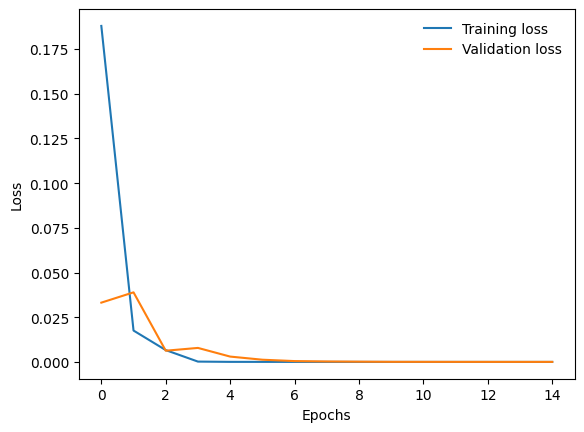

In [20]:
# Grafico de perdida de entrenamiento
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

## Test del modelo entrenado

In [21]:
# Cargar modelo desde archivo .pth
def load_trained_model(model_path='clasificacion_spam_model.pth'):
    # Crear la arquitectura del modelo (mismo que usaste para entrenar)
    model_name = 'dccuchile/bert-base-spanish-wwm-uncased'
    loaded_model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    
    # Cargar los pesos entrenados
    loaded_model.load_state_dict(torch.load(model_path, map_location=device))
    loaded_model.to(device)
    loaded_model.eval()  # Modo evaluación
    
    return loaded_model

spam_classifier_loaded = load_trained_model('clasificacion_spam_model.pth')

# Probar con el modelo cargado
print("🧪 Probando modelo cargado...")
nada = test_model(spam_classifier_loaded)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧪 Probando modelo cargado...
Test Loss: 0.0122 Acc: 0.9950


## Test del modelo, con ejemplos

In [30]:
from tabulate import tabulate

# Hacer predicciones en el dataset de test con visualización profesional
def predict_test_dataset(model, test_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, 1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

# Generar predicciones
print("🔬 Generando predicciones del modelo...")
predictions = predict_test_dataset(spam_classifier_loaded, test_loader)

# Crear tabla con formato profesional
print("\n" + "="*120)
print("📊 RESULTADOS DE CLASIFICACIÓN - DATASET DE PRUEBA")
print("="*120)

# Preparar datos para la tabla
table_data = []
for i in range(min(20, len(x_test))):  # Mostrar solo primeros 20
    texto_completo = x_test[i]  # Sin truncar
    real = "No Spam" if y_test[i] == 0 else "Spam"
    pred = "No Spam" if predictions[i] == 0 else "Spam"
    estado = "✅" if y_test[i] == predictions[i] else "❌"
    
    table_data.append([i, texto_completo, real, pred, estado])

# Mostrar tabla con formato grid y sin límites de ancho
headers = ["#", "Texto", "Real", "Predicción", "Estado"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Estadísticas resumidas
total = len(y_test)
correctos = sum(1 for i in range(len(y_test)) if y_test[i] == predictions[i])
accuracy = (correctos / total) * 100

🔬 Generando predicciones del modelo...

📊 RESULTADOS DE CLASIFICACIÓN - DATASET DE PRUEBA
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+--------------+----------+
|   # | Texto                                                                                                                                                                                                                                | Real    | Predicción   | Estado   |
+=====+======================================================================================================================================================================================================================================+=========+==============+==========+
|   0 | BBVA Su cuenta ha sido suspendida temporalmente por seguridad para desbloquea

## Metricas del Modelo

F1 score, accuracy, exactitud, recall y Precision

In [26]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

# Función simplificada para calcular solo métricas generales
def calcular_metricas_principales(y_true, y_pred):
    """
    Calcula solo las métricas principales del modelo
    """
    # Métricas principales
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("=" * 80)
    print("📊 MÉTRICAS DE EVALUACIÓN DEL MODELO")
    print("=" * 80)
    
    # Tabla de métricas principales
    print("\n🎯 MÉTRICAS GENERALES:")
    metrics_data = [
        ["Accuracy (Exactitud)", f"{accuracy:.4f}", f"{accuracy*100:.2f}%"],
        ["Precision (Precisión)", f"{precision:.4f}", f"{precision*100:.2f}%"],
        ["Recall (Sensibilidad)", f"{recall:.4f}", f"{recall*100:.2f}%"],
        ["F1-Score", f"{f1:.4f}", f"{f1*100:.2f}%"]
    ]
    
    from tabulate import tabulate
    print(tabulate(metrics_data, headers=["Métrica", "Valor", "Porcentaje"], 
                   tablefmt="grid", floatfmt=".4f"))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

metricas = calcular_metricas_principales(y_test, predictions)

print("✅ Métricas calculadas correctamente")

📊 MÉTRICAS DE EVALUACIÓN DEL MODELO

🎯 MÉTRICAS GENERALES:
+-----------------------+---------+--------------+
| Métrica               |   Valor | Porcentaje   |
+=======================+=========+==============+
| Accuracy (Exactitud)  |  0.9950 | 99.50%       |
+-----------------------+---------+--------------+
| Precision (Precisión) |  0.9950 | 99.50%       |
+-----------------------+---------+--------------+
| Recall (Sensibilidad) |  0.9950 | 99.50%       |
+-----------------------+---------+--------------+
| F1-Score              |  0.9950 | 99.50%       |
+-----------------------+---------+--------------+
✅ Métricas calculadas correctamente
